<a href="https://colab.research.google.com/github/Emilyhu8381/Non_hermitian_skin_effect_simulation/blob/main/NHSE_Hatano_Nelson_plot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 0. Operators/gates basics
# 1. Hatano-Nelson Hamiltonian (2**6 by 2**6)
# 2. unitary extension of HN model (2**7 by 2**7)
# 3. ansatz for HN model  (initial layer + depth * single layer)
# 4. Quimb TensorNetwork optimization (the target is a trotterized result)
# 5. Convert tensor network to Qiskit quantum circuit; define initially prepared state
# 6. get statevector and measurement counts at each time step
# 7. post-selection of spinup ancilla qubit
# 8. dynamical density evolution ni(T) calculation
# 9. NHSE dynamics plot of HN model (fig. S2)

In [ ]:
import qiskit
import qiskit_aer
import qiskit_algorithms
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, AncillaRegister
from qiskit.quantum_info import Statevector, state_fidelity, Operator, Pauli
from qiskit.circuit import Parameter
from qiskit.circuit.library import U3Gate, CXGate
from qiskit.circuit.library import IGate, XGate, YGate, ZGate, UnitaryGate, RXGate
from qiskit import transpile
from qiskit_aer import AerSimulator, StatevectorSimulator

import quimb as qu
import quimb.tensor as qtn

import numpy as np
import math
import matplotlib.pyplot as plt

In [ ]:
# 0. Operators/gates basics

# Pauli matrices
pauli_x = Pauli('X')
pauli_y = Pauli('Y')
pauli_z = Pauli('Z')

# Pauli lowering/rising operators
sigma_x = pauli_x.to_matrix()
sigma_y = pauli_y.to_matrix()
sigma_z = pauli_z.to_matrix()
identity = [[1,0], [0,1]]
identity = np.array(identity)
sigma_plus = (sigma_x + 1j *sigma_y)/2
sigma_minus = (sigma_x - 1j *sigma_y)/2

In [ ]:
# 1. Hatano-Nelson Hamiltonian (2**6 by 2**6)

# H_HN= -\sum^{L-2}_{j=0} ( (J+\gamma)X^+_j*X^-_{j+1} + (J-\gamma)X^-_j*X^+_j+1)
# X^+_j = \ket{\uparrow}\bra{\uparrow},  X^-_j = \ket{\downarrow}\bra{\downarrow}

def HN_ham (length_l:int, J, gamma):
    H1=np.zeros((2**(length_l), 2**(length_l)), dtype=complex)
    H2=np.zeros((2**(length_l), 2**(length_l)), dtype=complex)

    # (J+\gamma) H1 part
    for i in range(length_l-1): # 0,1,2,3,4
        sigma_prod = np.kron(sigma_plus, sigma_minus)

        if i > 0:
            pre_sigma = identity
            for _ in range(i-1):
                pre_sigma = np.kron(pre_sigma, identity)
            result = np.kron(pre_sigma, sigma_prod)
        else:
            result = sigma_prod


        if i < (length_l-2):
            post_sigma = identity
            for _ in range(length_l-3-i):
                post_sigma = np.kron(post_sigma,identity)
            result = np.kron(result, post_sigma)
        else:
            result = result
        H1 += result
    H1 = -1 * (J+gamma) * H1


    # (J-\gamma) H2 part
    for i in range(length_l-1):
        sigma_prod = np.kron(sigma_minus, sigma_plus)

        if i > 0:
            pre_sigma = identity
            for _ in range(i-1):
                pre_sigma = np.kron(pre_sigma, identity)
            result = np.kron(pre_sigma, sigma_prod)
        else:
            result = sigma_prod


        if i < (length_l-2):
            post_sigma = identity
            for _ in range(length_l-3-i):
                post_sigma = np.kron(post_sigma,identity)
            result = np.kron(result, post_sigma)
        else:
            result = result

        H2 += result
    H2 = -1 * (J-gamma) * H2

    H = H1 + H2
    return H

In [ ]:
# 2. unitary extension of HN hamiltonian (2**7 by 2**7)

H = HN_ham(length_l=6, J = 2, gamma=0.5)

tot_t = 4
delta_t = 0.1

# matrix extension (2**6 by 2**6 --> 2**7 by 2**7)
R_HN = np.exp(-1j * H * delta_t)
R_HN_daggar = (R_HN.transpose()).conjugate()
identity_64 = identity
for i in range(5):
    identity_64 = np.kron(identity_64, identity)
C_H = -1* np.sqrt(identity_64 - R_HN  * R_HN_daggar)
B_H = -1 * C_H
D_H= R_HN
top_H = np.hstack((R_HN, B_H))
bottom_H = np.hstack((C_H, D_H))
U_HN = np.vstack((top_H, bottom_H))  # eqn. (S8)

# numerical calculation [U_HN]^{T\delta_t}, RHS of eqn. (S10)
exp_HN_T = U_HN **(tot_t/delta_t)


In [ ]:
# 3. ansatz for HN model (initial layer + depth * single layer)

def initial_layer(TN_circ, qubit_no: int, gate_round=None):
    for i in range(qubit_no):
        params = qu.randn(3, dist='uniform')
        TN_circ.apply_gate(
            'U3', *params, i,
            parametrize=True, gate_round=gate_round
        )


def single_layer(TN_circ, qubit_no: int, gate_round=None):
    # even-odd pairs
    for i in range(0, qubit_no - 1, 2):
        TN_circ.apply_gate('CX', i, i + 1, gate_round=gate_round)

    for i in range(qubit_no-1):
        params = qu.randn(3, dist='uniform')
        TN_circ.apply_gate('U3', *params, i, gate_round=gate_round, parametrize=True)

    for i in range(0, qubit_no - 1, 2):
        TN_circ.apply_gate('CX', i, i + 1, gate_round=gate_round)


    # odd-even pairs
    for i in range(1, qubit_no - 1, 2):
        TN_circ.apply_gate('CX', i, i + 1, gate_round=gate_round)
        # yes, but for

    for i in range(1, qubit_no):
        params = qu.randn(3, dist='uniform')
        TN_circ.apply_gate('U3', *params, i, gate_round=gate_round, parametrize=True)

    for i in range(1, qubit_no - 1, 2):
        TN_circ.apply_gate('CX', i, i + 1, gate_round=gate_round)



def ansatz_circuit(n, depth):
    TN_circ = qtn.Circuit(n)
    initial_layer(TN_circ, qubit_no=n, gate_round=0)

    for r in range(1, depth+1):
        single_layer(TN_circ, qubit_no=n, gate_round=r)

    return TN_circ


In [ ]:
# 4. Quimb TensorNetwork optimization (the target is a trotterized result)

# TN_circ configuration
n = 7
depth = 8
TN_circ = ansatz_circuit(n=n, depth=depth)

# target unitary operator (an analytical results without any gates/ansatz defined)
U_dense = exp_HN_T
U = qtn.Tensor(
    data=U_dense.reshape([2] * (2 * n)),
    inds=[f'k{i}' for i in range(n)] + [f'b{i}' for i in range(n)],
    tags={'U_TARGET'}
)

# Quimb Tensor Network (trainable)
V = TN_circ.uni

def loss(V, U):
    return 1 - abs((V.H & U).contract(all, optimize='auto-hq')) / 2**n

loss(V, U)

tnopt = qtn.TNOptimizer(
    V,
    loss,
    loss_constants = {'U':U}, # supply U to the loss fuction as a constant TN
    tags=['U3'],              # only optimize U3 tensors
    autodiff_backend='jax',   # use 'autograd' for non-compiled optimization
    optimizer='L-BFGS-B',      # the optimization algorithm
)

# optimize params of the tensor network
V_opt = tnopt.optimize_basinhopping(n=500, nhop=10)

# update gate parameters
TN_circ.update_params_from(V_opt)
TN_circ.gates



/Users/qingyan/ENTER/envs/qccmp/lib/python3.10/site-packages/quimb/tensor/circuit.py:2352: FutureWarning: In future the tensor network returned by ``circ.uni`` will not be transposed as it is currently, to match the expectation from ``U = circ.uni.to_dense()`` behaving like ``U @ psi``. You can retain this behaviour with ``circ.get_uni(transposed=True)``.
  warnings.warn(
  0%|          | 0/5000 [00:00<?, ?it/s]/Users/qingyan/ENTER/envs/qccmp/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:69: UserWarning: Explicitly requested dtype <class 'jax.numpy.complex128'> requested in astype is not available, and will be truncated to dtype complex64. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/Users/qingyan/ENTER/envs/qccmp/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:69:

(<Gate(label=U3, params=[1.8715143  0.17712137 1.5713431 ], qubits=(0,), round=0, parametrize=True))>,
 <Gate(label=U3, params=[-1.6362904   0.34940645  0.7916432 ], qubits=(1,), round=0, parametrize=True))>,
 <Gate(label=U3, params=[1.5869175 2.4297252 1.446126 ], qubits=(2,), round=0, parametrize=True))>,
 <Gate(label=U3, params=[ 0.53569955 -0.8144802  -0.46885374], qubits=(3,), round=0, parametrize=True))>,
 <Gate(label=U3, params=[-1.3412476 -2.4069788  2.503533 ], qubits=(4,), round=0, parametrize=True))>,
 <Gate(label=U3, params=[ 2.017557    2.5538967  -0.16678226], qubits=(5,), round=0, parametrize=True))>,
 <Gate(label=U3, params=[2.2915282 1.4252152 1.518683 ], qubits=(6,), round=0, parametrize=True))>,
 <Gate(label=CX, params=[], qubits=(0, 1), round=1)>,
 <Gate(label=CX, params=[], qubits=(2, 3), round=1)>,
 <Gate(label=CX, params=[], qubits=(4, 5), round=1)>,
 <Gate(label=U3, params=[ 0.75342864  0.97540677 -0.17911218], qubits=(0,), round=1, parametrize=True))>,
 <Gate(l

In [ ]:
# 5. Convert tensor network to Qiskit quantum circuit; define initially prepared state

gate_list = []
param_list = []
qubit_list = []
order_list = []


for _ in TN_circ.gates:
    gate_list.append(_.label)
    param_list.append(_.params)
    qubit_list.append(_.qubits)
    order_list.append(_.round)

quantum_circuit = []
for i, (a,b,c,d) in enumerate(zip(gate_list, param_list, qubit_list, order_list)):
    #quimb_gates.append(a,b,c,d)
    quantum_circuit.append((a,b,c,d))



# define an intially prepared state
 # physical qubit (|↓↓↓↑↓↓⟩ + |↓↓↑↓↓↓⟩)/ 2 ； initial ancilla qubit is |↑⟩
initial_state = Statevector.from_label('1101110') + Statevector.from_label('1110110')
initial_state = initial_state / np.linalg.norm(initial_state.data)


# create an Qiskit quantum circuit object
qc = QuantumCircuit(7)
qc.initialize(initial_state, range(7))
qc.set_statevector(initial_state)

for gate, params, qubits, order in quantum_circuit:
    if gate == 'U3':
        qc.append(U3Gate(*params), qubits)
    elif gate == 'CX':
        qc.append(CXGate(), qubits)


# a list with gate; params; qubit; order layout
quantum_circuit

[('U3', array([1.8715143 , 0.17712137, 1.5713431 ], dtype=float32), (0,), 0),
 ('U3',
  array([-1.6362904 ,  0.34940645,  0.7916432 ], dtype=float32),
  (1,),
  0),
 ('U3', array([1.5869175, 2.4297252, 1.446126 ], dtype=float32), (2,), 0),
 ('U3',
  array([ 0.53569955, -0.8144802 , -0.46885374], dtype=float32),
  (3,),
  0),
 ('U3', array([-1.3412476, -2.4069788,  2.503533 ], dtype=float32), (4,), 0),
 ('U3',
  array([ 2.017557  ,  2.5538967 , -0.16678226], dtype=float32),
  (5,),
  0),
 ('U3', array([2.2915282, 1.4252152, 1.518683 ], dtype=float32), (6,), 0),
 ('CX', array([], dtype=float64), (0, 1), 1),
 ('CX', array([], dtype=float64), (2, 3), 1),
 ('CX', array([], dtype=float64), (4, 5), 1),
 ('U3',
  array([ 0.75342864,  0.97540677, -0.17911218], dtype=float32),
  (0,),
  1),
 ('U3',
  array([-1.2911035e-03,  2.7439839e-01,  1.2979286e+00], dtype=float32),
  (1,),
  1),
 ('U3', array([ 1.1645647,  0.55543  , -1.2030418], dtype=float32), (2,), 1),
 ('U3', array([ 0.8015613, -1.3693

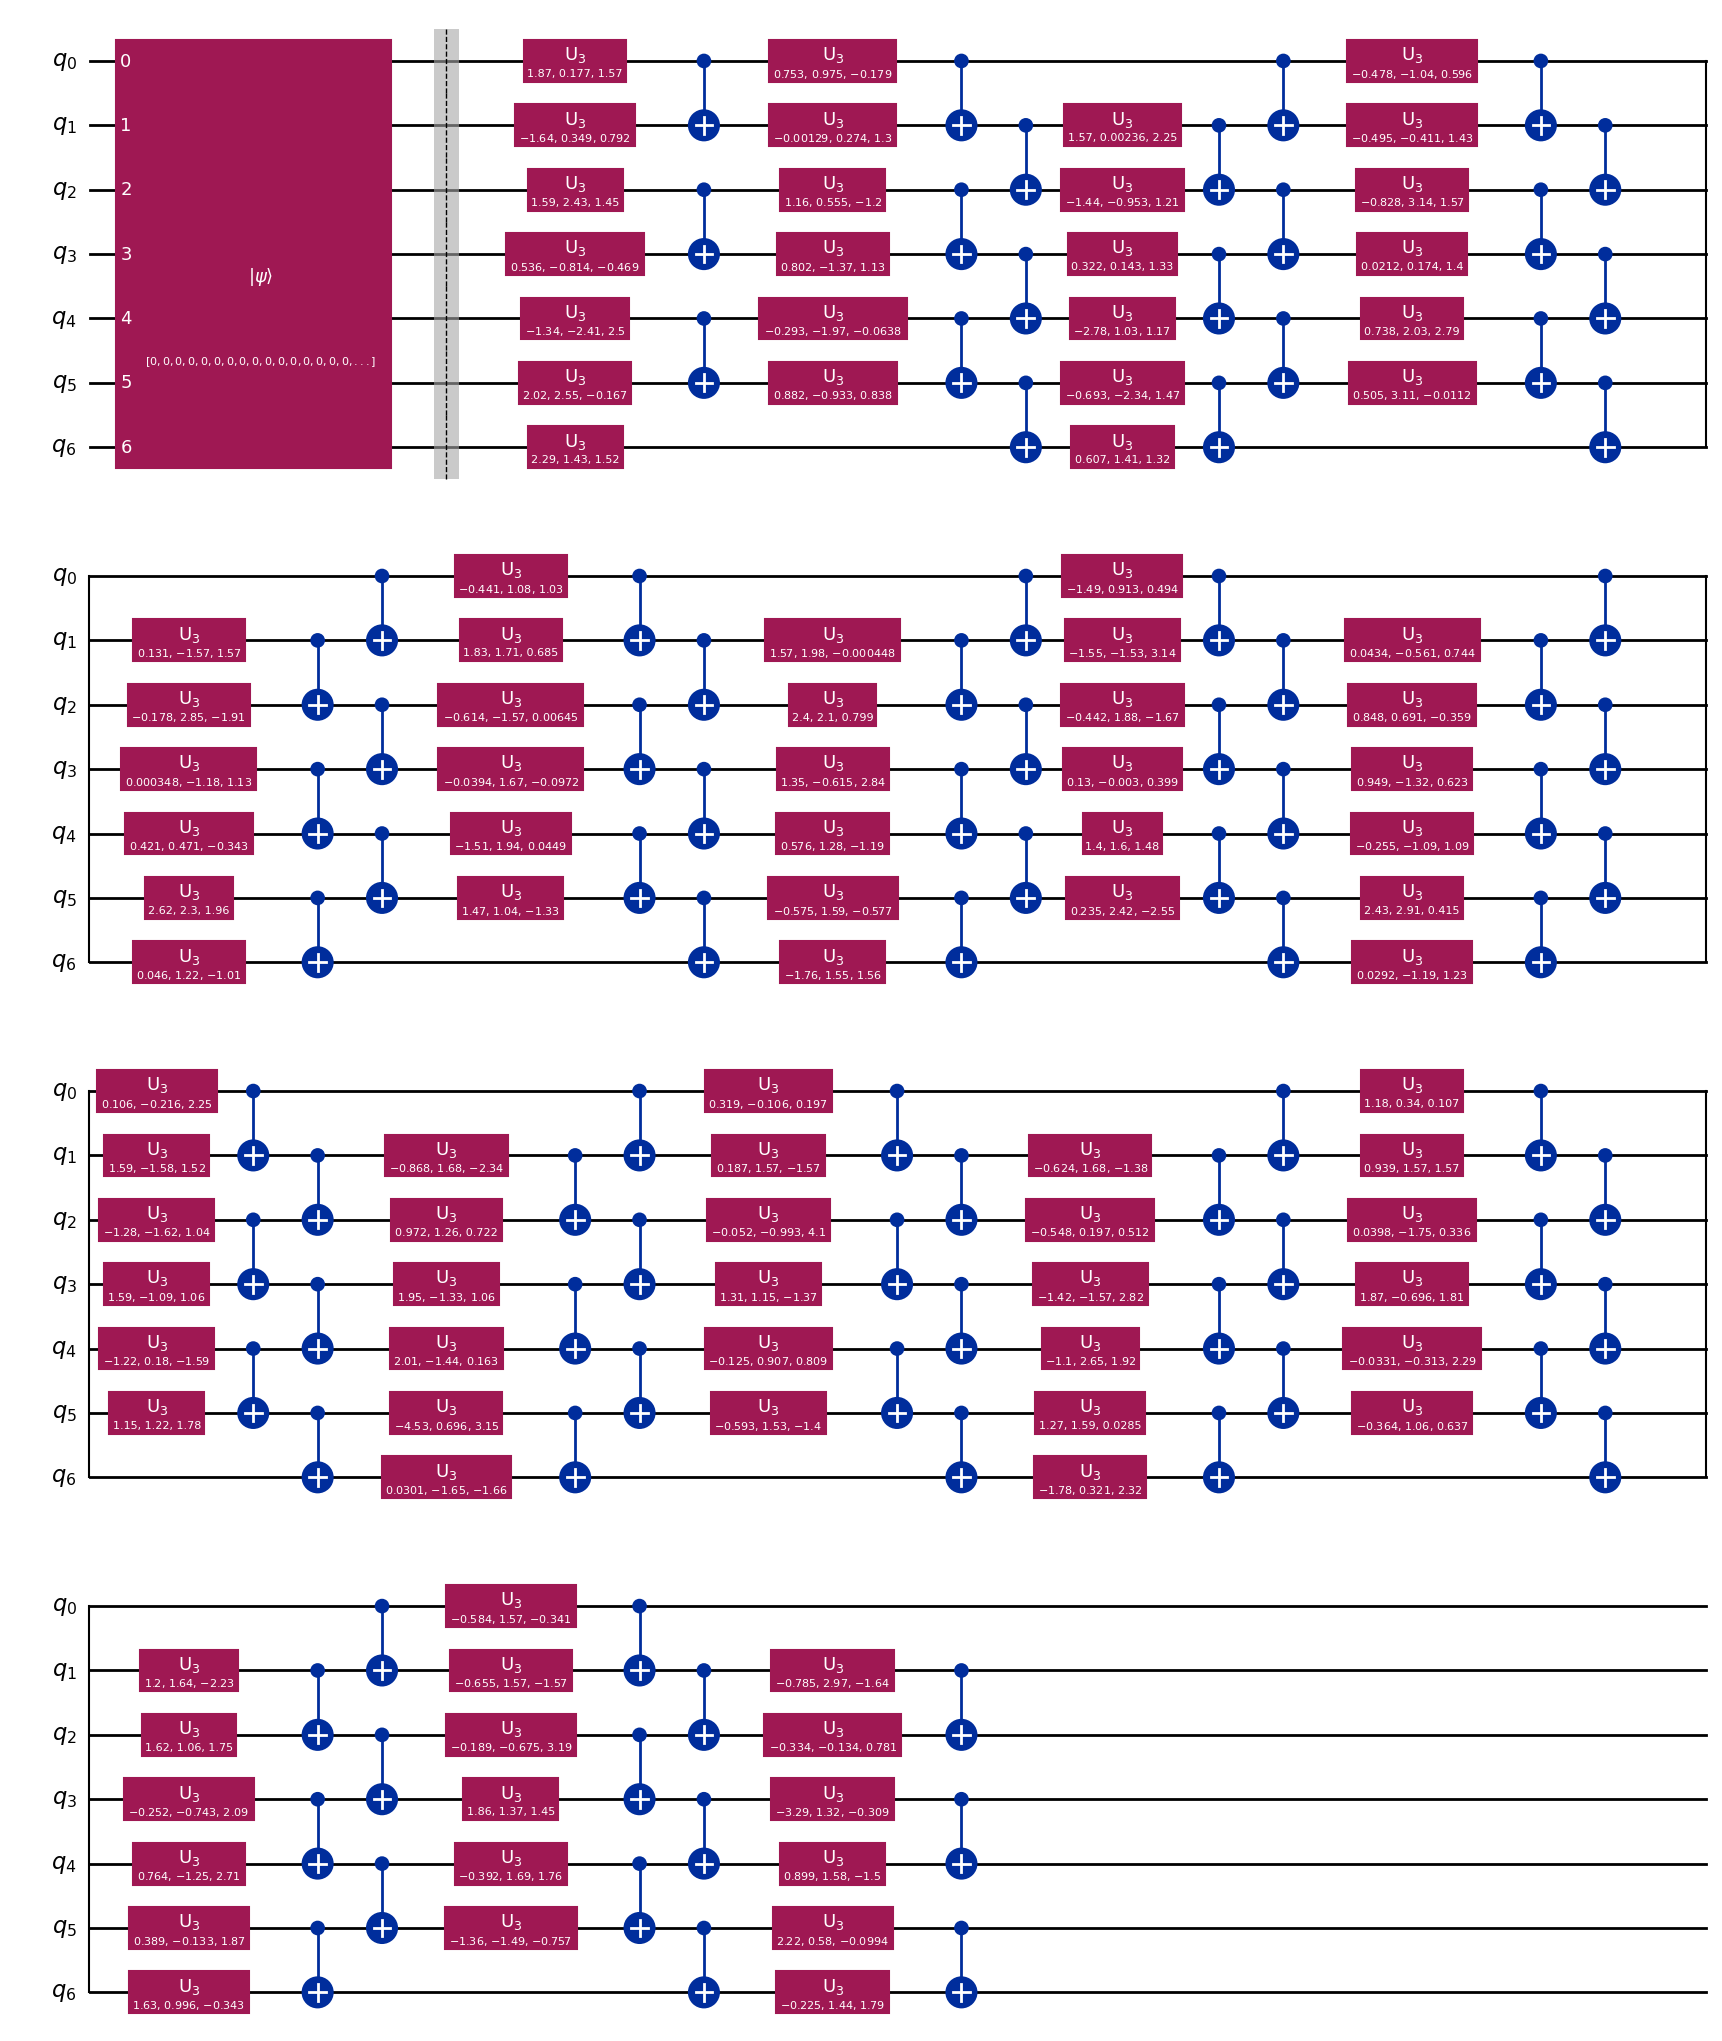

In [ ]:
# initially prepared statevector (128*1 column vector) +
# 1 * initial U3 layer + 8 * single ansatz layer

# sanity check
qc.draw('mpl')

In [ ]:
# 6. get statevector and measurement counts at each time step

initial_state = Statevector.from_label('1101110') + Statevector.from_label('1110110')
initial_state = initial_state / np.linalg.norm(initial_state.data)
qc = QuantumCircuit(7)
qc.initialize(initial_state, range(7))


# at each time step, add new gates and get the statevector information and measurements
tot_t = 4
timestep = 0.5
statevectors_list = []
measurement_counts_list= []
statevector_backend = AerSimulator(method='statevector')
measurement_backend = AerSimulator(method='statevector')


for t in np.arange(0, 4, 0.5):
    # Add gates corresponding to this time step
    for gate, params, qubits, order in quantum_circuit:
        if t > order * (tot_t  / len(quantum_circuit)):
            if gate == 'U3':
                qc.append(U3Gate(*params), qubits)
            elif gate == 'CX':
                qc.append(CXGate(), qubits)


    statevectors_list.append(Statevector.from_instruction(qc))

    qc.measure_all()
    job_sim = measurement_backend.run(qc,shots=10000)
    result_sim = job_sim.result()
    counts = result_sim.get_counts()
    measurement_counts_list.append(counts)


    # Reset the state to the statevector from last timestep
    if t < 8:
        statevector = statevectors_list[-1]
        qc = QuantumCircuit(7)  # Create a new quantum circuit
        qc.initialize(statevector.data, range(7))



In [ ]:
# 7. post-selection of spinup ancilla qubit

# post-selection
measurement_counts_postselection = []

for _ in measurement_counts_list:
    dict = {}
    for bitstring, count in _.items():
        if bitstring[-1] == '0':
            dict[bitstring[:6]]=count
    measurement_counts_postselection.append(dict)



# convert post-selected measurement outcomes to new statevector
statevectors_postselection = []
physical_qubits = 6
dim = 2 ** physical_qubits


for _ in measurement_counts_postselection:
    statevector_reconstructed = np.zeros(dim, dtype=complex)

    for bitstring, count in _.items():
        sv = Statevector.from_label(bitstring)
        statevector_reconstructed += np.sqrt(count) * sv.data

    norm = np.linalg.norm(statevector_reconstructed)
    statevector_reconstructed /= norm # normalize the statevector

    statevectors_postselection.append(statevector_reconstructed)


In [ ]:
# 8. dynamical density evolution ni(T) calculation
# compute the density profile at each time step

Z_operator_list = []
for i in range(physical_qubits): # physical_qubits=6
    operators = [identity] * physical_qubits
    operators[i] = sigma_z  # Replace the i-th position with sigma_z

    # Compute the tensor product using np.kron
    Z_i = operators[0]
    for op in operators[1:]:
        Z_i = np.kron(Z_i, op)

    Z_operator_list.append(Z_i)


# n_i(T) = (<psi(T) | Z_i | psi(T)> + 1) / 2
site_timestep_list = []  # 6*(1*8); 6 lattice site 8 time steps
for op in Z_operator_list:
    timestep_list = []   # 1*8; one lattice site 6 time steps
    for state in statevectors_postselection:
        psi_T = state
        psi_T_dagger = np.conjugate(psi_T.T)
        fermion_density = np.dot(psi_T_dagger, np.dot(op, psi_T))
        fermion_density = (fermion_density.real+1)/2
        timestep_list.append(fermion_density) # density dynamics for site i


    site_timestep_list.append(timestep_list)
    # i.e, from left to right, it is the density dynamics
    # for top to down, it is the layout of 0th to 5th lattice site

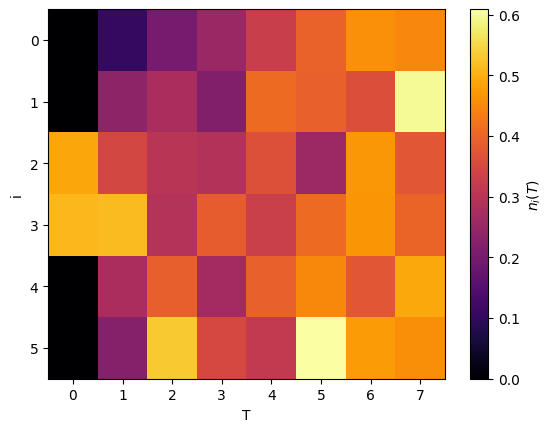

In [ ]:
# 9. NHSE dynamics plot of HN model (fig. S2)

dataset = np.array(site_timestep_list)
plt.imshow(dataset, aspect='auto', cmap='inferno')
plt.colorbar(label="$n_i(T)$")

plt.xlabel("T")
plt.ylabel("i")
plt.show()


# at each timestep (each column)
# the probability of finding the fermion at any site should sum up to 1
# here the probability explodes